In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
import time
from collections import Counter
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPooling2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing import image as IMG

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [22]:
# (X_train, X_test,y_train,y_test)
with open('image_data_array.pickle','rb') as file:
    data = pickle.load(file)

In [23]:
X_train, X_test,X_val,y_train,y_test,y_val = data[0],data[1],data[2],data[3],data[4],data[5]

#Split data into train and validation set
#X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state = 17,shuffle =True,test_size =.2)

y_train_hotcode = keras.utils.to_categorical(y_train)
y_val_hotcode = keras.utils.to_categorical(y_val)
y_test_hotcode = keras.utils.to_categorical(y_test)

1379

#### Data Augment and CNN

In [34]:
IMGgen = IMG.ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)

In [75]:
train_ds = IMGgen.flow(X_train, y_train, batch_size=32)
val_ds = IMGgen.flow(X_val, y_val, batch_size=32)
test_ds = IMGgen.flow(X_test, y_test, batch_size=32)

In [37]:
if os.path.exists("cnn_model.h5") == False:
    ### basic CNN model
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=X_train.shape[1:]))

    cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(8, activation='softmax'))  # 10 target classes
     

    cnn.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        #loss ='categorical_crossentropy',
        #optimizer= keras.optimizers.Adam(learning_rate=0.01),
        #optimizer = optimizer,
        optimizer = 'Adam',
        metrics=['accuracy'],
    )
    cnn.summary()
    
    cnn_result = cnn.fit(train_ds,
             validation_data= val_ds,
             epochs=200, verbose=1, batch_size = 32,
             callbacks = tf.keras.callbacks.EarlyStopping(patience=10))  # track progress as we fit

    cnn.save("model_h5_file/cnn_model.h5")
    
    with open('cnn_result.pickle','wb')as file:
        pickle.dump(cnn_result, file)

else: 
    cnn = keras.models.load_model('model_h5_file/cnn_model.h5')
    
    with open('cnn_result.pickle','rb') as file:
        cnn_result = pickle.load(file)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 128)     

Epoch 42/200
130/130 [==============================] - 237s 2s/step - loss: 1.2598 - accuracy: 0.5180 - val_loss: 1.3350 - val_accuracy: 0.5112
Epoch 43/200
130/130 [==============================] - 163s 1s/step - loss: 1.2476 - accuracy: 0.5233 - val_loss: 1.3311 - val_accuracy: 0.5120
Epoch 44/200
130/130 [==============================] - 149s 1s/step - loss: 1.2287 - accuracy: 0.5240 - val_loss: 1.3142 - val_accuracy: 0.4989
INFO:tensorflow:Assets written to: ram://fe7effc9-1b48-44e7-b2c4-e2d5ff3c8d35/assets


In [49]:
y_pred= np.argmax(cnn.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.5271936185641769
recall : 0.48803251338257125
precision : 0.5953684584743663
f1 : 0.5184241793909208


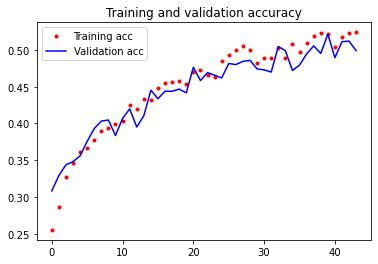

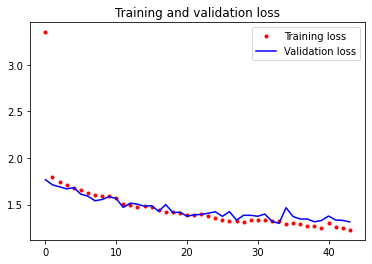

In [50]:
acc = cnn_result.history['accuracy']
val_acc = cnn_result.history['val_accuracy']
loss = cnn_result.history['loss']
val_loss = cnn_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r.', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
category_int_map = {'Gasoline Can': 0,
                     'Hammer': 1,
                     'Screw Driver': 4,
                     'Wrench': 6,
                     'Rope': 3,
                     'Pebbels': 2,
                     'Toolbox': 5,
                     'pliers': 7}
int_category_map = {0: 'Gasoline Can',
                     1: 'Hammer',
                     4: 'Screw Driver',
                     6: 'Wrench',
                     3: 'Rope',
                     2: 'Pebbels',
                     5: 'Toolbox',
                     7: 'pliers'}

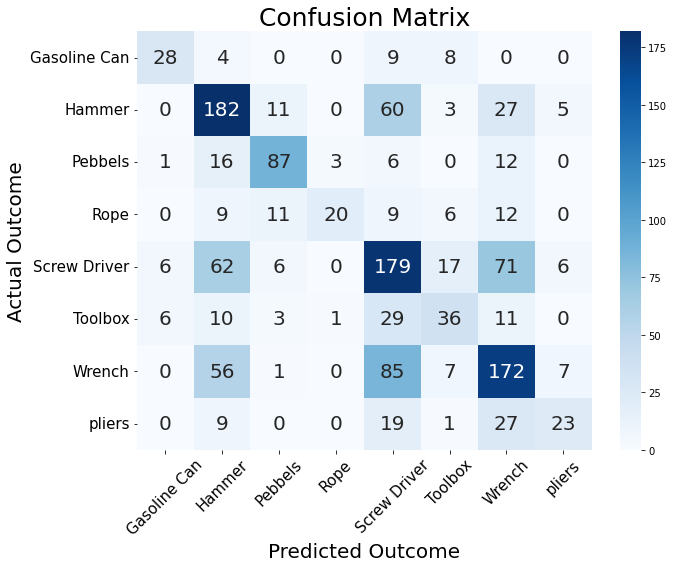

In [72]:
plt.figure(figsize=(10,8))
#plt.subplot(131)
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();